In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from libs.model import BMP
from datasets import transforms
import imageio
from collections import OrderedDict
from utils import imutils
from utils.imutils import encode_cmap
from libs.PAR import PAR
from utils.camutils import refine_cam_with_bkg_v3_test
def cam2vis(_imgs, cam):
    cam = F.interpolate(cam, size=_imgs.shape[2:], mode='bilinear', align_corners=False)
    cam = cam.cpu()
    cam_max = cam.max(dim=1)[0]
    cam_heatmap = plt.get_cmap('jet')(cam_max.numpy())[:,:,:,0:3]*255
    cam_cmap = torch.from_numpy(cam_heatmap).permute([0, 3, 1, 2])
    cam_img = cam_cmap*0.5 + _imgs.cpu()*0.5
    return cam_img

In [18]:
###Prepare Images
img_name = "demo_inputs/2007_000175.jpg"
image = np.asarray(imageio.imread(img_name))
image = transforms.normalize_img(image)
image = np.transpose(image, (2, 0, 1))
inputs = torch.from_numpy(image).unsqueeze(0)#.cuda(0)

In [19]:
##Prepare our Model
model = BMP(backbone="mit_b1",
            stride=[4, 2, 2, 1],
            num_classes=21,
            embedding_dim=256,
            pretrained=True,
            pooling="gmp")

par = PAR(num_iter=10, dilations=[1,2,4,8,12,24])
param_groups = model.get_param_groups()

trained_state_dict = torch.load("bmp_checkpoint.pth", map_location="cpu")

new_state_dict = OrderedDict()
for k, v in trained_state_dict.items():
    k = k.replace('module.', '')
    new_state_dict[k] = v

model.load_state_dict(state_dict=new_state_dict, strict=True)
model.eval()

BMP(
  (encoder): mit_b1(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_features=64, bia

In [20]:
inputs = inputs.cuda(0)
model = model.cuda(0)
par = par.cuda(0)

with torch.no_grad(), torch.cuda.device(0):

    _, _, h, w = inputs.shape
    ratio = 512 / max(h,w)
    _h, _w = int(h*ratio), int(w*ratio)
    inputs = F.interpolate(inputs, size=(_h, _w), mode='bilinear', align_corners=False)

    segs_list = []
    cls, segs, attn_pred, cams = model(inputs, )
    segs = F.interpolate(segs, size=(inputs.shape[2], inputs.shape[3]), mode='bilinear', align_corners=False)
    cams = F.interpolate(cams, size=(inputs.shape[2], inputs.shape[3]), mode='bilinear', align_corners=False)

###Normalization
vis_segs = segs.clone()
vis_segs = vis_segs + F.adaptive_max_pool2d(-vis_segs, (1, 1))
vis_segs /= F.adaptive_max_pool2d(vis_segs, (1, 1)) + 1e-5

vis_cams = cams.clone()
vis_cams = vis_cams + F.adaptive_max_pool2d(-vis_cams, (1, 1))
vis_cams /= F.adaptive_max_pool2d(vis_cams, (1, 1)) + 1e-5

###Propagating Seed with our BSP
bg_cam = torch.cat([vis_segs[:, 0, :, :].unsqueeze(1).clone(), vis_cams.clone()], dim=1)
bg_cam = refine_cam_with_bkg_v3_test(par, imutils.denormalize_img2(inputs.clone()), cams=bg_cam, labels=torch.ones(1, 21),img_box=[[ 0, inputs.shape[-2], 0, inputs.shape[-1]]])
bg_cam = F.interpolate(bg_cam, size=(inputs.shape[2], inputs.shape[3]), mode="bilinear", align_corners=False) #上采样回原图大小

vis_bmps = bg_cam.clone()
vis_bmps = vis_bmps + F.adaptive_max_pool2d(-vis_bmps, (1, 1))
vis_bmps /= F.adaptive_max_pool2d(vis_bmps, (1, 1)) + 1e-5

###Generate Visualizations
inputs_denorm = imutils.denormalize_img2(inputs.clone())
obj_num = 0
for i, cls_socre in enumerate(cls[0]):
    if cls_socre > 0:
        if obj_num == 0:
            vis_cams_cls = cam2vis(inputs_denorm.clone(), vis_cams[:, i, :, :].unsqueeze(1)) #cam object class
            vis_bmp_cls = cam2vis(inputs_denorm.clone(), vis_bmps[:, i+1, :, :].unsqueeze(1)) #bmp object class
            vis_segs_cls = cam2vis(inputs_denorm.clone(), vis_segs[:, i+1, :, :].unsqueeze(1)) #seg object class
        else:
            vis_cams_cls = torch.cat([vis_cams_cls,cam2vis(inputs_denorm.clone(), vis_cams[:, i, :, :].unsqueeze(1))], dim=3) #cam object class
            vis_bmp_cls = torch.cat([vis_bmp_cls, cam2vis(inputs_denorm.clone(), vis_bmp_cls[:, i+1, :, :].unsqueeze(1))], dim=3) #bmp object class
            vis_segs_cls = torch.cat([vis_segs_cls, cam2vis(inputs_denorm.clone(), vis_segs[:, i+1, :, :].unsqueeze(1))], dim=3) #seg object class
        obj_num = obj_num + 1
vis_img = np.array(inputs_denorm[0, :, :, :].cpu().data).transpose(1, 2, 0)
vis_segs_cls = np.uint8(np.array(vis_segs_cls.cpu().data)[0, :, :, :].transpose(1, 2, 0))
vis_cams_cls = np.uint8(np.array(vis_cams_cls.cpu().data)[0, :, :, :].transpose(1, 2, 0))
vis_bmp_cls = np.uint8(np.array(vis_bmp_cls.cpu().data)[0, :, :, :].transpose(1, 2, 0))


In [21]:
###Generate Visualizations
inputs_denorm = imutils.denormalize_img2(inputs.clone())
#vis_segs = F.interpolate(vis_segs, size=vis_segs.shape[1:], mode='bilinear', align_corners=False)
obj_num = 0
for i, cls_socre in enumerate(cls[0]):
    if cls_socre > 0:
        if obj_num == 0:
            vis_cams_cls = cam2vis(inputs_denorm.clone(), vis_cams[:, i, :, :].unsqueeze(1)) #cam object class
            vis_bmp_cls = cam2vis(inputs_denorm.clone(), vis_bmps[:, i+1, :, :].unsqueeze(1)) #cam object class
            vis_segs_cls = cam2vis(inputs_denorm.clone(), vis_segs[:, i+1, :, :].unsqueeze(1)) #seg object class
        else:
            vis_cams_cls = torch.cat([vis_cams_cls,cam2vis(inputs_denorm.clone(), vis_cams[:, i, :, :].unsqueeze(1))], dim=3) #cam object class
            vis_segs_cls = torch.cat([vis_segs_cls, cam2vis(inputs_denorm.clone(), vis_segs[:, i+1, :, :].unsqueeze(1))], dim=3) #seg object class
            vis_bmp_cls = torch.cat([vis_bmp_cls, cam2vis(inputs_denorm.clone(), vis_bmps[:, i+1, :, :].unsqueeze(1))], dim=3) #seg object class
        obj_num = obj_num + 1
#vis_segs_cls = torch.cat([vis_segs_cls, cam2vis(inputs_denorm.clone(), vis_cams[:, 0, :, :].unsqueeze(1))], dim=3) #background class
vis_img = np.array(inputs_denorm[0, :, :, :].cpu().data).transpose(1, 2, 0)
vis_segs_cls = np.uint8(np.array(vis_segs_cls.cpu().data)[0, :, :, :].transpose(1, 2, 0))
vis_cams_cls = np.uint8(np.array(vis_cams_cls.cpu().data)[0, :, :, :].transpose(1, 2, 0))
vis_bmp_cls = np.uint8(np.array(vis_bmp_cls.cpu().data)[0, :, :, :].transpose(1, 2, 0))
seg_results = encode_cmap(np.array(torch.argmax(segs, dim=1)[0, :, :].cpu().data))

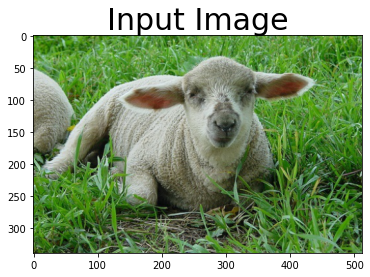

In [22]:
##Visualizing Input Image
plt.figure()
plt.title('Input Image',fontsize= 30)
plt.imshow(vis_img)

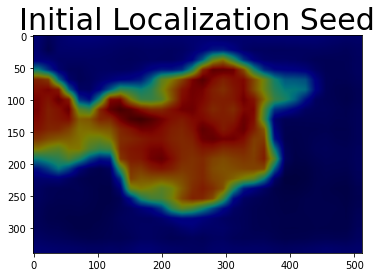

In [23]:
##Visualizing Localization Seed
plt.figure()
plt.title('Initial Localization Seed',fontsize=30)
plt.imshow(vis_cams_cls)

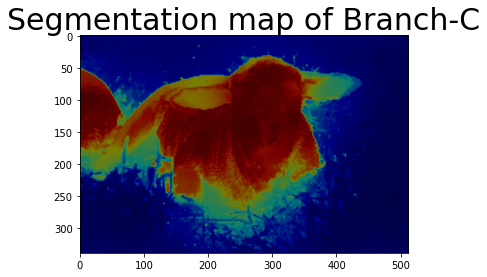

In [24]:
##Visualizing Output of Branch-C (Propagting Seeds with Our BSP)
plt.figure()
plt.title('Segmentation map of Branch-C',fontsize=30)
plt.imshow(vis_bmp_cls)

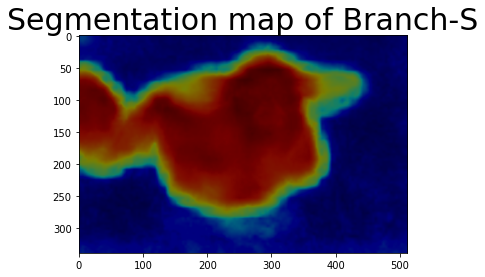

In [25]:
##Visualizing Output of Branch-S
plt.figure()
plt.title('Segmentation map of Branch-S',fontsize=30)
plt.imshow(vis_segs_cls)

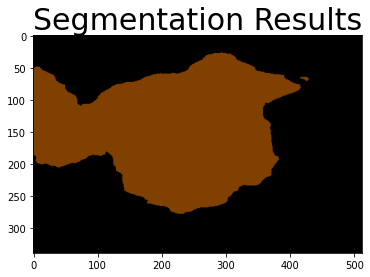

In [26]:
##Visualizing Segmentation Results
plt.figure()
plt.title('Segmentation Results',fontsize=30)
plt.imshow(seg_results)